## <font color='darkblue'>Preface</font>
([article source](https://realpython.com/python-keras-text-classification/)) <font size='3ptx'><b>Imagine you could know the mood of the people on the Internet. Maybe you are not interested in its entirety, but only if people are today happy on your favorite social media platform. After this tutorial, you’ll be equipped to do this. While doing this, you will get a grasp of current advancements of (deep) neural networks and how they can be applied to text.</b></font>

Reading the mood from text with machine learning is called [**sentiment analysis**](https://realpython.com/sentiment-analysis-python/), and it is one of the prominent use cases in text classification. This falls into the very active research field of [**natural language processing**](https://realpython.com/nltk-nlp-python/) (NLP). Other common use cases of text classification include detection of spam, auto tagging of customer queries, and categorization of text into defined topics. So how can you do this?

<a id='sect0'></a>
### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'><b><a href='#sect1'>Choosing a Data Set</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>Defining a Baseline Model</a></b></font>
* <font size='3ptx'><b><a href='#sect3'>A Primer on (Deep) Neural Networks</a></b></font>
* <font size='3ptx'><b><a href='#sect4'>What Is a Word Embedding?</a></b></font>
* <font size='3ptx'><b><a href='#sect5'>Convolutional Neural Networks (CNN)</a></b></font>
* <font size='3ptx'><b><a href='#sect6'>Hyperparameters Optimization </a></b></font>

In [81]:
import functools
import gensim
import gensim.downloader
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec

from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
plt.style.use('ggplot')

In [2]:
RANDOM_STATE = 42
''' Random state use in many occasions such as spliting dataset into train/test.'''

TEST_SIZE = 0.25
''' The percentage of dataset used for testing. '''

' The percentage of dataset used for testing. '

<a id='sect1'></a>
## <font color='darkblue'>Choosing a Data Set</font>
<font size='3ptx'><b>Before we start, let’s take a look at what data we have. Go ahead and download the data set from the [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) from the UCI Machine Learning Repository.</b></font>

By the way, this repository is a wonderful source for machine learning data sets when you want to try out some algorithms. This data set includes labeled reviews from IMDb, Amazon, and Yelp. <b>Each review is marked with a score of 0 for a negative sentiment or 1 for a positive sentiment.</b>

Extract the folder into a `sentiment_labelled_sentences` folder:

In [3]:
!ls data/sentiment_labelled_sentences/*.txt | grep -v 'readme.txt'

data/sentiment_labelled_sentences/amazon_cells_labelled.txt
data/sentiment_labelled_sentences/imdb_labelled.txt
data/sentiment_labelled_sentences/yelp_labelled.txt


In [4]:
!head -n 3 data/sentiment_labelled_sentences/yelp_labelled.txt

Wow... Loved this place.	1
Crust is not good.	0
Not tasty and the texture was just nasty.	0


 Next, let's go ahead and load the data with Pandas:

In [5]:
filepath_dict = {'yelp':   'data/sentiment_labelled_sentences/yelp_labelled.txt',
                 'amazon': 'data/sentiment_labelled_sentences/amazon_cells_labelled.txt',
                 'imdb':   'data/sentiment_labelled_sentences/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df.sample(n=3)

,sentence,label,source
493,CONCLUSION: Very filling meals.,1,yelp
357,As always the evening was wonderful and the fo...,1,yelp
43,"On a positive note, our server was very attent...",1,yelp


This looks about right. With this data set, you are able to train a model to predict the sentiment of a sentence. Take a quick moment to think about how you would go about predicting the data.

One way you could do this is to <b>count the frequency of each word in each sentence and tie this count back to the entire set of words in the data set</b> (<font color='brown'>Also known as [**Bag of words**](https://en.wikipedia.org/wiki/Bag-of-words_model)</font>). You would start by taking the data and creating a vocabulary from all the words in all sentences. The collection of texts is also called a <font color='darkblue'><b>corpus</b></font> in NLP.

<b>The vocabulary in this case is a list of words that occurred in our text where each word has its own index. This enables you to create a vector for a sentence</b>. You would then take the sentence you want to vectorize, and you count each occurrence in the vocabulary. <b>The resulting vector will be with the length of the vocabulary and a count for each word in the vocabulary</b>.

<b>The resulting vector is also called a <font color='darkblue'>feature vector</font>. In a feature vector, each dimension can be a numeric or categorical feature</b>, like for example the height of a building, the price of a stock, or, in our case, the count of a word in a vocabulary. These feature vectors are a crucial piece in data science and machine learning, as the model you want to train depends on them.

Let’s quickly illustrate this. Imagine you have the following two sentences:

In [6]:
sentences = ['John likes ice cream', 'John hates chocolate.']

Next, you can use the [**CountVectorizer**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) provided by the [**scikit-learn**](https://scikit-learn.org/stable/index.html) library to vectorize sentences. <b>It takes the words of each sentence and creates a vocabulary of all the unique words in the sentences</b>. This vocabulary can then be used to create a feature vector of the count of the words:

In [7]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

This vocabulary serves also as an index of each word. Now, you can take each sentence and get the word occurrences of the words based on the previous vocabulary. <b>The vocabulary consists of all five words in our sentences, each representing one word in the vocabulary</b> (<font color='brown'>How about unseen words in future corpus or data?</font>). When you take the previous two sentences and transform them with the [**CountVectorizer**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) you will get a vector representing the count of each word of the sentence:

In [8]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

Now, you can see the resulting feature vectors for each sentence based on the previous vocabulary. For example, if you take a look at the first item, you can see that both vectors have a 1 there. This means that both sentences have one occurrence of `John`, which is in the first place in the vocabulary.

This is considered a [**Bag-of-words (BOW)**](https://en.wikipedia.org/wiki/Bag-of-words_model) model, which is a common way in NLP to create vectors out of text. Each document is represented as a vector. You can use these vectors now as feature vectors for a machine learning model. This leads us to our next part, defining a baseline model.

<a id='sect2'></a>
## <font color='darkblue'>Defining a Baseline Model</font> ([back](#sect0))
<font size='3ptx'><b>When you work with machine learning, one important step is to define a baseline model</b></font>

<b>This usually involves a simple model, which is then used as a comparison with the more advanced models that you want to test</b>. In this case, you’ll use the baseline model to compare it to the more advanced methods involving (deep) neural networks, the meat and potatoes of this tutorial.

<b>First, you are going to split the data into a training and testing set which will allow you to evaluate the accuracy and see if your model generalizes well.</b> This means whether the model is able to perform well on data it has not seen before. This is a way to see if the model is [**overfitting**](https://en.wikipedia.org/wiki/Overfitting).

<b>[Overfitting](https://en.wikipedia.org/wiki/Overfitting) is when a model is trained too well on the training data</b>. You want to avoid overfitting, as this would mean that the model mostly just memorized the training data. This would account for a large accuracy with the training data but a low accuracy in the testing data.

![overfitting](images/overfitting.PNG)
<br/>

<font color='orange'>**Extends reading**</font>: [TensorFlow Core - Overfit and underfit ](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)
<br/>

We start by taking the [**Yelp data set**](https://www.yelp.com/dataset) which we extract from our concatenated data set. From there, we take the sentences and labels. The .values returns a NumPy array instead of a Pandas Series object which is in this context easier to work with:

In [9]:
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [10]:
sentences_train[:3]

array(['The turkey and roast beef were bland.',
       'Spend your money and time some place else.',
       'Great atmosphere, friendly and fast service.'], dtype=object)

<b>Here we will use again on the previous BOW model to vectorize the sentences</b>. You can use again the [**CountVectorizer**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for this task. Since you might not have the testing data available during training, you can create the vocabulary using only the training data. Using this vocabulary, you can create the feature vectors for each sentence of the training and testing set:

In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [12]:
print(X_train.shape)
X_train.__class__

(750, 1728)


scipy.sparse.csr.csr_matrix

<b>You can see that the resulting feature vectors have 750 samples which are the number of training samples we have after the train-test split. Each sample has 1728 dimensions which is the size of the vocabulary.</b> Also, you can see that we get a <b><font color='darkblue'>sparse matrix</font></b> ([Compressed Sparse Row matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)). This is a data type that is optimized for matrices with only a few non-zero elements, which only keeps track of the non-zero elements reducing the memory load.

[**CountVectorizer**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) performs [tokenization](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) which separates the sentences into a set of tokens as you saw previously in the vocabulary. <b>It additionally removes punctuation and special characters and can apply other preprocessing to each word</b>. If you want, you can use a custom tokenizer from the [**NLTK**](https://realpython.com/python-nltk-sentiment-analysis/) library with the [**CountVectorizer**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) or use any number of the customizations which you can explore to improve the performance of your model.

<font color='orange'>**Extends reading**</font>: [Demystifying the Difference Between Multi-Class and Multi-Label Classification Problem Statements in Deep Learning](https://www.analyticsvidhya.com/blog/2021/07/demystifying-the-difference-between-multi-class-and-multi-label-classification-problem-statements-in-deep-learning/)
<br/>

The classification model we are going to use is the [**logistic regression**](https://realpython.com/logistic-regression-python/) which is a simple yet powerful linear model that is mathematically speaking in fact a form of regression between 0 and 1 based on the input feature vector. By specifying a cutoff value (<font color='brown'>by default 0.5</font>), the regression model is used for classification. You can use again scikit-learn library which provides the [**LogisticRegression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier:

In [13]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [14]:
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.816


Another low-standard approach to calculate the baseline is using [**DummyClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) which provides some strategies you can choose to produce the baseline score for future comparison with more complex models:
* **most_frequent**: Always returns the most frequent class label in the observed `y` (default)
* **stratified**: Randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. 
* **uniform**: Generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.

In [15]:
classifier = DummyClassifier()
classifier.fit(X_train, y_train)

DummyClassifier()

In [16]:
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.488


<b>You can see that the logistic regression reached an impressive 81.6%</b>, but let’s have a look how this model performs on the other data sets that we have. In this script, we perform and evaluate the whole process for each data set that we have:

In [17]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.2%}'.format(source, score))

Accuracy for yelp data: 81.60%
Accuracy for amazon data: 84.40%
Accuracy for imdb data: 72.73%


Great! You can see that this fairly simple model achieves a fairly good accuracy. It would be interesting to see whether we are able to outperform this model. In the next part, we will get familiar with (deep) neural networks and how to apply them to text classification.

<a id='sect3'></a>
## <font color='darkblue'>A Primer on (Deep) Neural Networks</font> ([back](#sect0))
* <font size='3ptx'><b><a href='#sect3_1'>Introducing Keras</a></b></font>
* <font size='3ptx'><b><a href='#sect3_2'>Installing Keras</a></b></font>
* <font size='3ptx'><b><a href='#sect3_3'>Your First Keras Model</a></b></font>
<br/>

<font size='3ptx'><b>You might have experienced some of the excitement and fear related to [artificial intelligence](https://realpython.com/python-ai-neural-network/) and deep learning. </b> On a lighter note, AI researchers all agreed that they did not agree with each other when AI will exceed Human-level performance. According to this [paper](https://arxiv.org/abs/1705.08807) we should still have some time left.</font>

<b>Neural networks play a crucial role in the latest developments in AI</b>. It all started with a famous [paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) in 2012 by [Geoffrey Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton) and his team, which outperformed all previous models in the famous [**ImageNet Challenge**](https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge).

[**Neural networks**](https://en.wikipedia.org/wiki/Neural_network), or sometimes called artificial neural network (ANN) or feedforward neural network, are computational networks which were vaguely inspired by the neural networks in the human brain. They consist of neurons (<font color='brown'>also called nodes</font>) which are connected like in the graph below.

**You start by having a layer of input neurons where you feed in your feature vectors and the values are then feeded forward to a hidden layer**. At each connection, you are feeding the value forward, while the value is multiplied by a weight and a bias is added to the value. This happens at every connection and at the end you reach an output layer with one or more output nodes.

<font color='orange'>**Extends reading**</font>: [Introduction to Machine Learning with Python](https://www.oreilly.com/library/view/introduction-to-machine/9781449369880/) - [Neural Networks (Deep Learning)](https://notebook.community/tleonhardt/machine_learning/SL3_Neural_Networks)

If you want to have a binary classification you can use one node, but if you have multiple categories you should use multiple nodes for each category:
![NN graph](images/nn_graph.PNG)
<br/>

You can have as many hidden layers as you wish. In fact, a neural network with more than one hidden layer is considered a deep neural network. Don’t worry: I won’t get here into the mathematical depths concerning neural networks. But if you want to get an intuitive visual understanding of the math involved, you can check out the [YouTube Playlist](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) by Grant Sanderson. The formula from one layer to the next is this short equation:
![NN graph](images/nn_math_formula.PNG)
<br/>

All of those have to be then summed and passed to a function `f`. This function is considered the [**activation function**](https://en.wikipedia.org/wiki/Activation_function) and there are various different functions that can be used depending on the layer or the problem. It is generally common to use a [**rectified linear unit**](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (ReLU) for hidden layers, a [**sigmoid function**](https://en.wikipedia.org/wiki/Sigmoid_function) for the output layer in a binary classification problem, or a [**softmax function**](https://en.wikipedia.org/wiki/Softmax_function) for the output layer of multi-class classification problems.

<font color='orange'>**Extends reading**</font>: [mlmastery - How to Choose an Activation Function for Deep Learning](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/)

You might already wonder how the weights are calculated, and this is obviously the most important part of neural networks, but also the most difficult part. **The algorithm starts by initializing the weights with random values and they are then trained with a method called** [**backpropagation**](https://en.wikipedia.org/wiki/Backpropagation).

This is done by using optimization methods (<font color='brown'>also called optimizer</font>) like the [**gradient descent**](https://en.wikipedia.org/wiki/Gradient_descent) in order to reduce the error between the computed and the desired output (<font color='brown'>also called target output</font>). **The error is determined by a** [**loss function**](https://en.wikipedia.org/wiki/Loss_function) **whose loss we want to minimize with the optimizer**. The whole process is too extensive to cover here, but I’ll refer again to the Grant Sanderson playlist and the Deep Learning book by Ian Goodfellow I mentioned before.

What you have to know is that there are various optimization methods that you can use, but **the most common optimizer currently used is called [Adam](https://arxiv.org/abs/1412.6980) which has a good performance in various problems**.

You can also use different loss functions, but in this tutorial you will only need the [**cross entropy**](https://en.wikipedia.org/wiki/Cross_entropy) loss function or more specifically binary cross entropy which is used for binary classification problems. Be sure to experiment with the various available methods and tools. Some researchers even claim in a recent [article](http://www.sciencemag.org/news/2018/05/ai-researchers-allege-machine-learning-alchemy?es_p=6976017) that the choice for the best performing methods borders on alchemy. The reason being that many methods are not well explained and consist of a lot of tweaking and testing.

<a id='sect3_1'></a>
### <font color='darkgreen'>Introducing Keras</font> ([back](#sect3))
<font size='3ptx'><b>[Keras](https://keras.io/) is a deep learning and neural networks API by [François Chollet](https://twitter.com/fchollet) which is capable of running on top of [Tensorflow](https://www.tensorflow.org/) (Google), [Theano](http://deeplearning.net/software/theano/) or [CNTK](https://www.microsoft.com/en-us/cognitive-toolkit/) (Microsoft).</b></font> 
    
    
To quote the wonderful book by François Chollet, Deep Learning with Python:
> Keras is a model-level library, providing high-level building blocks for developing deep-learning models. It doesn’t handle low-level operations such as tensor manipulation and differentiation. Instead, it relies on a specialized, well-optimized tensor library to do so, serving as the backend engine of Keras ([Source](https://realpython.com/asins/1617294438/))

<br/>

It is a great way to start experimenting with neural networks without having to implement every layer and piece on your own. For example [**Tensorflow**](https://www.tensorflow.org/) is a great machine learning library, but you have to implement a lot of boilerplate code to have a model running.

<a id='sect3_2'></a>
### <font color='darkgreen'>Installing Keras</font> ([back](#sect3))
Before installing Keras, you’ll need either Tensorflow, Theano, or CNTK. **In this tutorial we will be using Tensorflow so check out their installation guide [here](https://github.com/tensorflow/tensorflow#download-and-setup)**, but feel free to use any of the frameworks that works best for you. Keras can be installed using [PyPI](https://pypi.org/) with the following command:

In [18]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


You can choose the backend you want to have by opening the Keras configuration file which you can find here:

In [19]:
!cat $HOME/.keras/keras.json

{
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_last"
}

For more details check out the [Keras backends documentation](https://keras.io/backend/).

You might notice that we use float32 data in the configuration file. The reason for this is that neural networks are frequently used in GPUs, and the computational bottleneck is memory. <b>By using 32 bit, we are able reduce the memory load and we do not lose too much information in the process.</b>

<a id='sect3_3'></a>
### <font color='darkgreen'>Your First Keras Model</font> ([back](#sect3))
Now you are finally ready to experiment with Keras. Keras supports two main types of models. You have the [Sequential model API](https://keras.io/models/sequential/) which you are going to see in use in this tutorial and the [functional API](https://keras.io/models/model/) which can do everything of the Sequential model but it can be also used for advanced models with complex network architectures.

<b>The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras.</b> The most common layer is the [**Dense layer**](https://keras.io/layers/core/#dense) which is your regular densely connected neural network layer with all the weights and biases that you are already familiar with.

Let’s see if we can achieve some improvement to our previous logistic regression model. We can still use the `X_train` and `X_test` arrays that you built in our earlier example.

Before we build our model, we need to know the input dimension of our feature vectors. This happens only in the first layer since the following layers can do automatic shape inference. **In order to build the Sequential model, you can add layers one by one in order as follows**:

In [20]:
input_dim = X_train.shape[1]  # Number of features

In [21]:
def basic_dnn(input_dim: int, hidden_activation='relu', output_activation='sigmoid'):
    model = Sequential()
    model.add(layers.Dense(10, input_dim=input_dim, activation=hidden_activation))
    model.add(layers.Dense(1, activation=output_activation))
    return model

In [22]:
dnn_model = basic_dnn(input_dim)

2022-06-25 19:18:23.320857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-25 19:18:23.320921: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-25 19:18:23.320962: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-06-25 19:18:23.321364: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<b>Before you can start with the training of the model, you need to configure the learning process</b>. This is done with the [.compile()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) method. **This method specifies the optimizer and the loss function.**

Additionally, you can add a list of metrics which can be later used for evaluation, but they do not influence the training. In this case, **we want to use the [binary cross entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) and the [Adam optimizer](https://keras.io/api/optimizers/adam/) you saw in the primer mentioned before**. Keras also includes a handy [.summary()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) function to give an overview of the model and the number of parameters available for training:

<b><font color='darkred'>Question</font>: How to choose loss function and optimizer for multiple-label classification problem?</b>

In [23]:
dnn_model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                24260     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 24,271
Trainable params: 24,271
Non-trainable params: 0
_________________________________________________________________


Neat! You are almost there. Now it is time to start your training with the [.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function.

<b>Since the training in neural networks is an iterative process, the training won’t just stop after it is done. You have to specify the number of iterations you want the model to be training.</b> Those completed iterations are commonly called <font color='darkblue'><b>epochs</b></font>. We want to run it for 100 epochs to be able to see how the training loss and accuracy are changing after each epoch.

<b>Another parameter you have to your selection is the <font color='darkblue'>batch size</font>. The batch size is responsible for how many samples we want to use in one epoch, which means how many samples are used in one forward/backward pass</b>. This increases the speed of the computation as it need fewer epochs to run, but it also needs more memory, and the model may degrade with larger batch sizes. Since we have a small training set, we can leave this to a low batch size:

<b><font color='orange'>Extends reading</font></b>:
* [Difference Between a Batch and an Epoch in a Neural Network](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)
* [Epoch vs Batch Size vs Iterations](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9)

In [24]:
%%time
history = dnn_model.fit(
    X_train, y_train, 
    epochs=100,
    verbose=False,
    validation_data=(X_test, y_test),
    batch_size=10)

/root/Github/ml_courses/env/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
2022-06-25 19:18:24.036563: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 11.9 s, sys: 10.3 s, total: 22.3 s
Wall time: 13.5 s


<b>Now you can use the [.evaluate()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) method to measure the accuracy of the model</b>. You can do this both for the training data and testing data. We expect that the training data has a higher accuracy then for the testing data. <b>The longer you would train a neural network, the more likely it is that it starts overfitting.</b>

Note that if you rerun the [.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method, you’ll start off with the computed weights from the previous training. Make sure to call [clear_session()](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) before you start training the model again. Now let’s evaluate the accuracy of the model:

In [25]:
loss, accuracy = dnn_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = dnn_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7594


**You can already see that the model was overfitting since it reached 100% accuracy for the training set** (<font color='brown'>but only 77% in testing dataset</font>). But this was expected since the number of epochs was fairly large for this model. However, the accuracy of the testing set has already surpassed our previous logistic Regression with BOW model, which is a great step further in terms of our progress.

To make your life easier, you can use this little helper function to visualize the loss and accuracy for the training and testing data based on the [**History**](https://keras.io/callbacks/#history) callback. This callback, which is automatically applied to each Keras model, records the loss and additional [metrics](https://keras.io/metrics/) that can be added in the [.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. In this case, we are only interested in the accuracy. This helper function employs the [**matplotlib**](https://matplotlib.org/) plotting library:

In [52]:
history.history['val_loss'][:10]

[0.6920966506004333,
 0.685238778591156,
 0.6695584654808044,
 0.6345568895339966,
 0.5733045935630798,
 0.523374617099762,
 0.4893837869167328,
 0.48056790232658386,
 0.4775550663471222,
 0.47616586089134216]

In [27]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    min_val_loss = val_loss[0]
    min_val_loss_x = -1
    for x_val, vloss in zip(range(1, len(val_loss) + 1), val_loss):
        if vloss < min_val_loss:
            min_val_loss = vloss
            min_val_loss_x = x_val
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    
    plt.vlines(
        x=min_val_loss_x, ymin=0, ymax=1, color="black", linestyle="--",
        label=f'overfitting point (epochs={min_val_loss_x})')
    plt.legend(loc='center right')

To use this function, simply call <font color='blue'>plot_history()</font> with the collected accuracy and loss inside the `history` dictionary:

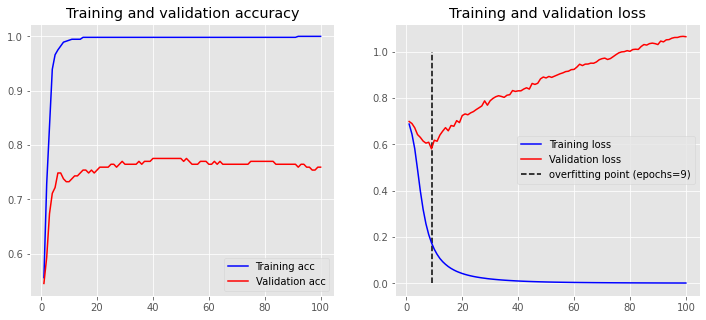

In [28]:
plot_history(history)

You can see that we have trained our model for too long since the training set reached 100% accuracy. <b>A good way to see when the model starts overfitting is when the loss of the validation data starts rising again</b>. This tends to be a good point to stop the model. You can see this around 8-10 epochs in this training.

In this case, our testing and validation set are the same, since we have a smaller sample size. <b>As we have covered before,</b> (deep) <b>neural networks perform best when you have a very large number of samples</b>. In the next part, you’ll see a different way to represent words as vectors. This is a very exciting and powerful way to work with words where you’ll see how to represent words as dense vectors.

<a id='sect4'></a>
## <font color='darkblue'>What Is a Word Embedding?</font> ([back](#sect0))
* <font size='3ptx'><b><a href='#sect4_1'>One-Hot Encoding</a></b></font>
* <font size='3ptx'><b><a href='#sect4_2'>Word Embeddings</a></b></font>
* <font size='3ptx'><b><a href='#sect4_3'>Keras Embedding Layer</a></b></font>
* <font size='3ptx'><b><a href='#sect4_4'>Using Pretrained Word Embeddings </a></b></font>
<br/>

<font size='3ptx'><b>Text is considered a form of sequence data similar to time series data that you would have in weather data or financial data</b>. In the previous BOW model, you have seen how to represent a whole sequence of words as a single feature vector. Now you will see how to represent each word as vectors.</font> 

There are various ways to vectorize text, such as:
* Words represented by each word as a vector
* Characters represented by each character as a vector
* N-grams of words/characters represented as a vector (<font color='brown'>N-grams are overlapping groups of multiple succeeding words/characters in the text</font>)

<br/>

In this tutorial, you’ll see how to deal with representing words as vectors which is the common way to use text in neural networks. Two possible ways to represent a word as a vector are one-hot encoding and word embeddings.

<a id='sect4_1'></a>
### <font color='darkgreen'>One-Hot Encoding (BoW)</font> ([back](#sect4))
<font size='3ptx'><b>The first way to represent a word as a vector is by creating a so-called [one-hot encoding](https://en.wikipedia.org/wiki/One-hot), which is simply done by taking a vector of the length of the vocabulary with an entry for each word in the corpus.</b></font>

In this way, you have for each word, given it has a spot in the vocabulary, a vector with zeros everywhere except for the corresponding spot for the word which is set to one. <b><font color='darkred'>As you might imagine, this can become a fairly large vector for each word and it does not give any additional information like the relationship between words</font></b>.

Let’s say you have a list of cities as in the following example:

In [29]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']

You can use scikit-learn and the [**LabelEncoder**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to encode the list of cities into categorical integer values like here:

In [30]:
encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1])

In [31]:
encoder.classes_

array(['Berlin', 'London', 'New York'], dtype='<U8')

Using this representation, you can use the [**OneHotEncoder**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) provided by scikit-learn to encode the categorical values we got before into a one-hot encoded numeric array. [**OneHotEncoder**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) expects each categorical value to be in a separate row, so you’ll need to reshape the array, then you can apply the encoder:

In [32]:
encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

You can see that categorical integer value represents the position of the array which is 1 and the rest is 0. This is often used when you have a categorical feature which you cannot represent as a numeric value but you still want to be able to use it in machine learning. One use case for this encoding is of course words in a text but it is most prominently used for categories. Such categories can be for example city, department, or other categories.

<a id='sect4_2'></a>
### <font color='darkgreen'>Word Embeddings</font> ([back](#sect4))
<font size='3ptx'><b>This method represents words as dense word vectors</b> (<font color='brown'>also called [**word embeddings**](https://en.wikipedia.org/wiki/Word_embedding)</font>) <b>which are trained unlike the one-hot encoding which are hardcoded</b>. This means that the word embeddings collect more information into fewer dimensions.</font>
<br/>
    
![word embedding](images/word_embedding.png)
<br/>

Note that the word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. <b>Their aim is to map semantic meaning into a geometric space. This geometric space is then called the <font color='darkblue'>embedding space</font>.</b>

<b>This would map semantically similar words close on the embedding space like numbers or colors.</b> If the embedding captures the relationship between words well, things like vector arithmetic should become possible. A famous example in this field of study is the ability to map [King - Man + Woman = Queen](https://www.technologyreview.com/s/541356/king-man-woman-queen-the-marvelous-mathematics-of-computational-linguistics/).

How can you get such a word embedding? You have two options for this. One way is to train your word embeddings during the training of your neural network. The other way is by using pretrained word embeddings which you can directly use in your model. There you have the option to either leave these word embeddings unchanged during training or you train them also.

<b><font color='orange'>Extends reading</font></b>: [Tensorflow - Train your own Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings)

Now you need to tokenize the data into a format that can be used by the word embeddings. Keras offers a couple of convenience methods for [text preprocessing](https://keras.io/preprocessing/text/) and [sequence preprocessing](https://keras.io/preprocessing/sequence/) which you can employ to prepare your text.

**You can start by using the** [**Tokenizer**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) **utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves**. You can add the parameter `num_words`, which is responsible for setting the size of the vocabulary. The most common `num_words` words will be then kept. I have the testing and training data prepared from the previous example:

In [33]:
sentences_train[:3]

array(['Give this one a look.  ',
       'In fact, this stinker smells like a direct-to-video release.  ',
       'Every single character was hilarious and deserved to be called a lead.  '],
      dtype=object)

In [34]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

In [35]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [36]:
vocab_size

2495

In [37]:
# The word is mapping to an integer as index of word learned from fit
print(sentences_train[2])
print(X_train[2])

Every single character was hilarious and deserved to be called a lead.  
[104, 321, 75, 13, 253, 3, 917, 9, 34, 918, 2, 254]


<b>The indexing is ordered after the most common words in the text, which you can see by the word `the` having the index 1</b>. It is important to note that the index 0 is reserved and is not assigned to any word. This zero index is used for padding, which I’ll introduce in a moment.

Unknown words (<font color='brown'>words that are not in the vocabulary</font>) are denoted in Keras with `word_count + 1` since they can also hold some information. You can see the index of each word by taking a look at the `word_index` dictionary of the Tokenizer object:

In [38]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 30
happy: 1813
sad: 2377


<b>One problem that we have is that each text sequence has in most cases different length of words.</b> To counter this, you can use [pad_sequence()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

Additionally you would want to add a `maxlen` parameter to specify how long the sequences should be. This cuts sequences that exceed that number. In the following code, you can see how to pad sequences with Keras:

In [39]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [40]:
# Show the first word index of each sentence
print(X_train.shape)
print(X_train[0, :])

(561, 100)
[165   6  23   2  80   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


The first values represent the index in the vocabulary as you have learned from the previous examples. <b>You can also see that the resulting feature vector contains mostly zeros, since you have a fairly short sentence</b>. In the next part you will see how to work with word embeddings in Keras.

<a id='sect4_3'></a>
### <font color='darkgreen'>Keras Embedding Layer</font> ([back](#sect4))
<font size='3ptx'>Notice that, at this point, our data is still hardcoded. We have not told Keras to learn a new embedding space through successive tasks. <b>Now you can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding</b></font>.

You will need the following parameters:
* `input_dim`: the size of the vocabulary
* `output_dim`: the size of the dense vector
* `input_length`: the length of the sequence


With the [**Embedding layer**](https://keras.io/api/layers/core_layers/embedding/) we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a [**Dense layer**](https://keras.io/api/layers/core_layers/dense/). In order to do this you have to add a [**Flatten layer**](https://keras.io/api/layers/reshaping_layers/flatten/) in between that prepares the sequential input for the [**Dense layer**](https://keras.io/api/layers/core_layers/dense/):

In [41]:
def dnn_model_with_embedding_layer(input_dim, input_length, embedding_dim = 50):
    embedding_dim = 50

    model = Sequential()
    model.add(layers.Embedding(input_dim=input_dim, 
                               output_dim=embedding_dim, 
                               input_length=input_length))    
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [42]:
model = dnn_model_with_embedding_layer(
    input_dim=vocab_size,
    input_length=maxlen)

In [43]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           124750    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 174,771
Trainable params: 174,771
Non-trainable params: 0
_________________________________________________________________


You can now see that we have 124,750 new parameters to train. This number comes from `vocab_size` times the `embedding_dim` (` 2495 * 50 = 124750`). These weights of the embedding layer are initialized with random weights and are then adjusted through backpropagation during training. This model takes the words as they come in the order of the sentences as input vectors. You can train it with the following:

In [44]:
%%time
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

CPU times: user 5.1 s, sys: 3.39 s, total: 8.49 s
Wall time: 4.81 s


In [45]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7112


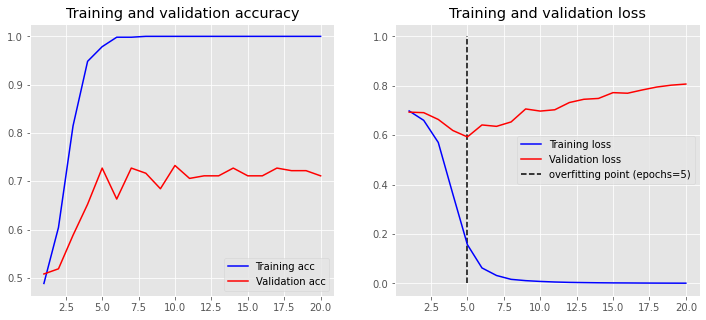

In [46]:
plot_history(history)

Another way to work with embeddings is by using a [**MaxPooling1D**](https://keras.io/api/layers/pooling_layers/max_pooling1d/)/[**AveragePooling1D**](https://keras.io/api/layers/pooling_layers/average_pooling1d/) or a [**GlobalMaxPooling1D**](https://keras.io/api/layers/pooling_layers/global_max_pooling1d/)/[**GlobalAveragePooling1D**](https://keras.io/api/layers/pooling_layers/global_average_pooling1d/) layer after the embedding. **You can think of the pooling layers as a way to downsample** (<font color='brown'>a way to reduce the size of</font>) the incoming feature vectors.

In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model:

In [47]:
def dnn_model_with_embedding_layer_and_pooling(input_dim, input_length, embedding_dim = 50):
    model = Sequential()
    model.add(layers.Embedding(input_dim=input_dim, 
                               output_dim=embedding_dim, 
                               input_length=input_length))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [48]:
model = dnn_model_with_embedding_layer_and_pooling(
    input_dim=vocab_size,
    input_length=maxlen)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           124750    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 125,271
Trainable params: 125,271
Non-trainable params: 0
_________________________________________________________________


The procedure for training does not change:

In [49]:
%%time
clear_session()
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

CPU times: user 10.4 s, sys: 8.41 s, total: 18.8 s
Wall time: 10.3 s


In [50]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7433


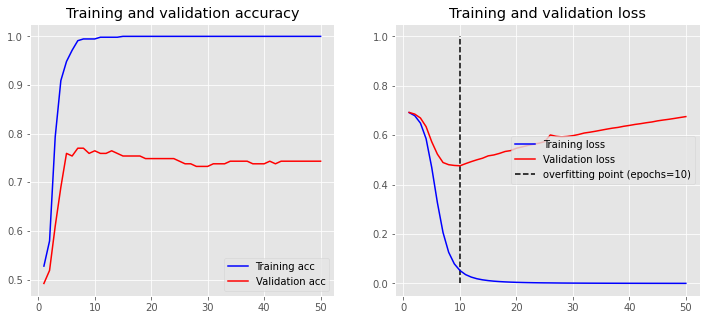

In [51]:
plot_history(history)

You can already see some improvements in our models. Next you’ll see how we can employ pretrained word embeddings and if they help us with our model.

<a id='sect4_4'></a>
### <font color='darkgreen'>Using Pretrained Word Embeddings</font> ([back](#sect4))
<font size='3ptx'><b>We just saw an example of jointly learning word embeddings incorporated into the larger model that we want to solve. Next we will see how to employ pretrained word embeddings and if they help us with our model.</b></font>

An alternative is to use a precomputed embedding space that utilizes a much larger corpus. It is possible to precompute word embeddings by simply training them on a large corpus of text. Among the most popular methods are [**Word2Vec**](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) developed by Google and [**GloVe**](https://nlp.stanford.edu/projects/glove/) (<font color='brown'>Global Vectors for Word Representation</font>) developed by the Stanford NLP Group.

Note that those are different approaches with the same goal. [**Word2Vec**](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) achieves this by employing neural networks and [**GloVe**](https://nlp.stanford.edu/projects/glove/) achieves this with a co-occurrence matrix and by using matrix factorization. **In both cases you are dealing with dimensionality reduction, but [Word2Vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) is more accurate and [GloVe](https://nlp.stanford.edu/projects/glove/) is faster to compute.**

<font color='orange'><b>Extends reading</b></font>: [fasttext - Library for efficient text classification and representation learning](https://fasttext.cc/docs/en/crawl-vectors.html)

**In this tutorial, you’ll see how to work with the [GloVe](https://nlp.stanford.edu/projects/glove/) word embeddings from the Stanford NLP Group as their size is more manageable than the [Word2Vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) word embeddings provided by Google**. Go ahead and download the 6B (<font color='brown'>trained on 6 billion words</font>) word embeddings from [here](https://nlp.stanford.edu/projects/glove/) (<font color='brown'>glove.6B.zip, 822 MB</font>).

You can find other word embeddings also on the [main GloVe page](https://nlp.stanford.edu/projects/glove/). You can find the pretrained Word2Vec embeddings by Google [here](https://code.google.com/archive/p/word2vec/). If you want to train your own word embeddings, you can do so efficiently with the [**gensim**](https://radimrehurek.com/gensim/index.html) Python package which uses Word2Vec for calculation. More details on how to do this [here](https://radimrehurek.com/gensim/models/word2vec.html).

Now that we got you covered, you can start using the word embeddings in your models. You can see in the next example how you can load the embedding matrix. Each line in the file starts with the word and is followed by the embedding vector for the particular word.

This is a large file with 400,000 lines, with each line representing a word followed by its vector as a stream of floats. For example, here are the first 50 characters of the first line:
```shell
$ head -n 1 data/glove_word_embeddings/glove.6B.50d.txt | cut -c-50
    the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.04445
```

<br/>

Since you don’t need all words, you can focus on only the words that we have in our vocabulary. Since we have only a limited number of words in our vocabulary, we can skip most of the 40000 words in the pretrained word embeddings:

In [55]:
#!pip3 install gensim

In [60]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [105]:
glove_vectors = gensim.downloader.load('glove-twitter-50')

[==================================================] 100.0% 199.5/199.5MB downloaded


In [106]:
# The word fector of word `the
the_wv = glove_vectors.get_vector('the')
print(the_wv.shape)
print(the_wv)

(50,)
[ 2.5320e-01 -1.4884e-02  5.9371e-01  1.5902e-01  1.2754e-01  2.2428e-01
  8.9421e-01  3.6396e-01 -3.1339e-01 -5.1857e-01  2.9637e-01 -4.1098e-02
 -6.4555e+00  3.2260e-01  3.7280e-01 -6.1690e-01  4.6744e-01  5.0600e-01
  3.1950e-02  1.0155e-01 -1.9615e-01  1.3364e-01 -2.7140e-01 -4.1728e-01
  7.7940e-03  1.3573e-01 -7.2992e-02  2.5208e-01  5.1148e-01  1.5120e-01
  8.4398e-02 -2.4791e-01 -1.5913e-01  1.5005e-01  7.7243e-01  3.6632e-01
 -9.8310e-02 -6.4317e-02 -7.1983e-04 -1.5231e-01 -1.4604e+00 -3.1696e-01
 -4.1762e-01  7.3363e-02  3.2043e-01  3.4324e-01  1.0895e-02 -2.8932e-01
  4.5493e-01  1.8659e-01]


In [73]:
# KeyError: "Key 'ababaccd' not present"
# unknown_wv = glove_vectors.get_vector('ababaccd')

In [107]:
glove_vectors.vector_size

50

In [108]:
list(tokenizer.word_index.items())[:3]

[('the', 1), ('a', 2), ('and', 3)]

In [109]:
index2word = {i:w for w, i in tokenizer.word_index.items()}
list(index2word.items())[:3]

[(1, 'the'), (2, 'a'), (3, 'and')]

In [110]:
def vector_of_word(word_index, index2word, w2v):
    try:
        w = index2word[word_index]
        return w2v.get_vector(w)
    except Exception:
        return np.zeros(w2v.vector_size)
    
glove_twitter_50_vector_of_word = functools.partial(vector_of_word, index2word=index2word, w2v=glove_vectors)

In [111]:
glove_twitter_50_vector_of_word(1)

array([ 2.5320e-01, -1.4884e-02,  5.9371e-01,  1.5902e-01,  1.2754e-01,
        2.2428e-01,  8.9421e-01,  3.6396e-01, -3.1339e-01, -5.1857e-01,
        2.9637e-01, -4.1098e-02, -6.4555e+00,  3.2260e-01,  3.7280e-01,
       -6.1690e-01,  4.6744e-01,  5.0600e-01,  3.1950e-02,  1.0155e-01,
       -1.9615e-01,  1.3364e-01, -2.7140e-01, -4.1728e-01,  7.7940e-03,
        1.3573e-01, -7.2992e-02,  2.5208e-01,  5.1148e-01,  1.5120e-01,
        8.4398e-02, -2.4791e-01, -1.5913e-01,  1.5005e-01,  7.7243e-01,
        3.6632e-01, -9.8310e-02, -6.4317e-02, -7.1983e-04, -1.5231e-01,
       -1.4604e+00, -3.1696e-01, -4.1762e-01,  7.3363e-02,  3.2043e-01,
        3.4324e-01,  1.0895e-02, -2.8932e-01,  4.5493e-01,  1.8659e-01],
      dtype=float32)

In [112]:
glove_twitter_50_vector_of_word(-1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [113]:
num_words = miss_words = 0
for w in tokenizer.word_index.keys():
    try:
        num_words += 1
        glove_vectors.get_vector(w)
    except:
        miss_words += 1
        
print(f'{(num_words-miss_words)/num_words:0.1%} words is covered from glove vector!')

93.0% words is covered from glove vector!


This means 93% of the vocabulary is covered by the pretrained model, which is a good coverage of our vocabulary. Let’s have a look at the performance when using the [**GlobalMaxPool1D layer**](https://keras.io/api/layers/pooling_layers/global_max_pooling1d/):

In [115]:
vocab_size = len(tokenizer.word_index) + 1  # Adding again 1 because of reserved 0 index
embedding_matrix = np.zeros((vocab_size, glove_vectors.vector_size))

for idx in range(1, vocab_size):
    embedding_matrix[idx] = glove_twitter_50_vector_of_word(idx)

print(embedding_matrix.shape)
embedding_matrix[1]

(2495, 50)


array([ 2.53199995e-01, -1.48839997e-02,  5.93710005e-01,  1.59020007e-01,
        1.27540007e-01,  2.24280000e-01,  8.94209981e-01,  3.63959998e-01,
       -3.13389987e-01, -5.18570006e-01,  2.96370000e-01, -4.10979986e-02,
       -6.45550013e+00,  3.22600007e-01,  3.72799993e-01, -6.16900027e-01,
        4.67440009e-01,  5.05999982e-01,  3.19500007e-02,  1.01549998e-01,
       -1.96150005e-01,  1.33640006e-01, -2.71400005e-01, -4.17279989e-01,
        7.79400021e-03,  1.35729998e-01, -7.29919970e-02,  2.52079993e-01,
        5.11479974e-01,  1.51199996e-01,  8.43980014e-02, -2.47909993e-01,
       -1.59130007e-01,  1.50049999e-01,  7.72430003e-01,  3.66320014e-01,
       -9.83100012e-02, -6.43170029e-02, -7.19829986e-04, -1.52309999e-01,
       -1.46039999e+00, -3.16960007e-01, -4.17620003e-01,  7.33629987e-02,
        3.20430011e-01,  3.43239993e-01,  1.08949998e-02, -2.89319992e-01,
        4.54930007e-01,  1.86590001e-01])

In [116]:
model = Sequential()
model.add(layers.Embedding(vocab_size, glove_vectors.vector_size, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           124750    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 125,271
Trainable params: 521
Non-trainable params: 124,750
_________________________________________________________________


In [117]:
%%time
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

CPU times: user 5.73 s, sys: 5.22 s, total: 11 s
Wall time: 7.03 s


In [118]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7273
Testing Accuracy:  0.6043


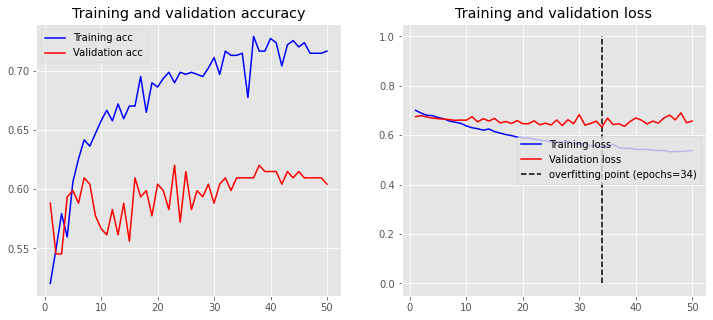

In [119]:
plot_history(history)

Since the word embeddings are not additionally trained, it is expected to be lower. But let’s now see how this performs if we allow the embedding to be trained by using `trainable=True`:

In [121]:
model = Sequential()
model.add(layers.Embedding(vocab_size, glove_vectors.vector_size, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           124750    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 125,271
Trainable params: 125,271
Non-trainable params: 0
_________________________________________________________________


In [122]:
%%time
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

CPU times: user 10.2 s, sys: 6.78 s, total: 17 s
Wall time: 9.32 s


In [123]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7005


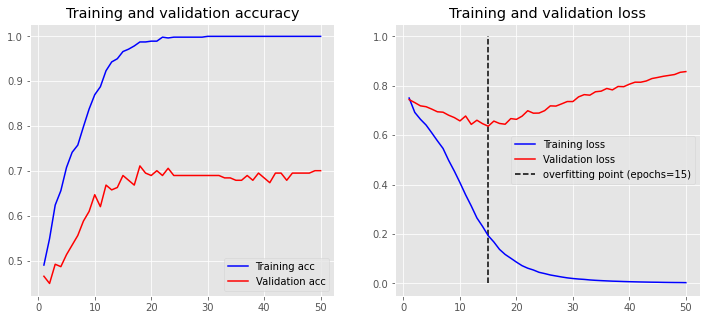

In [124]:
plot_history(history)

<b>You can see that it is most effective to allow the embeddings to be trained. When dealing with large training sets it can boost the training process to be much faster than without</b>. In our case it seemed to help but not by much. This does not have to be because of pretrained word embeddings.

Now it is time to focus on a more advanced neural network model to see if it is possible to boost the model and give it the leading edge over the previous models.

<a id='sect5'></a>
## <font color='darkblue'>Convolutional Neural Networks (CNN)</font> ([back](#sect0))
TBD

<a id='sect6'></a>
## <font color='darkblue'>Hyperparameters Optimization</font> ([back](#sect0))
TBD

## <font color='darkblue'>Supplement</font>
* [Matplotlib - Draw vertical line matplotlib](https://pythonguides.com/draw-vertical-line-matplotlib/)